#874353

# A2 Técnicas de Algoritmo em Ciência de Dados

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, average_precision_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, roc_curve, precision_recall_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from collections import Counter 

## Part 1 – Multi Layer Perceptron for regression

First, we want to load the datasetwith pandas and get a sample out of it:

In [6]:
data1 = pd.read_table('Part 1.tsv')
data1 = data1.sample(2000)

We'll split it into X (features) and y (the target column), and train and test sets, 70% of the data being for training:

In [7]:
X = data1[['feat_0', 'feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5']].to_numpy()
y = data1['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

Now we can move on to the Perceptron Regressor we wish to implement. Keep in mind we wish to have an algorithm with 5 hidden layers:

In [8]:
# functions for internal calculation
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def sigmoid_derivate(z):
    return sigmoid(z) * (1.0 - sigmoid(z))

class PerceptronRegressor(BaseEstimator):

    def __init__(self, n_hidden=100, epochs=100, learning_rate=0.0001, batch_size=100):
        self.n_hidden = n_hidden # arbitrary, but i chose to keep it easy to access (mostly to addapt for exercise 2)
        self.epochs = epochs 
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.weights = []

    # forward propagation
    def forward_prop(self, X): 
        self.z = []
        self.h = []

        # first layer
        self.z.append(X)
        self.h.append(X)
        
        # hidden layers
        for i in range(1,6):
            self.z.append(self.h[i-1] @ self.weights[i-1])
            self.h.append(sigmoid(self.z[i]))
            self.h[i] = np.c_[np.ones((self.h[i].shape[0], 1)), self.h[i]]

        # output layer
        self.z.append(self.h[5] @ self.weights[5])
        self.h.append(self.z[6])

        # return last one
        return self.h[6]

    def backward_prop(self, X, y):
        self.dweights = []
        self.delta = []

        # output layer (here we go backwards)
        self.delta.append(self.h[-1] - y) #delta[0] = delta5

        # other layers
        for i in range(4, -1, -1):
            self.delta.append(self.delta[-1] @ self.weights[i+1][1:,:].T * sigmoid_derivate(self.z[i + 1]) )#delta[5-i] = delta (i)

        # corrects our list of deltas so that we can update the weights
        self.delta.reverse()

        # weight update
        for i in range(len(self.weights)):
            self.dweights.append(self.h[i].T @ self.delta[i])
        return self.dweights

    # auxiliar functions
    def def_weights(self,input_dim, output_dim): # for initializing weights
        return np.random.randn(input_dim , output_dim)
    
    def update_weights(self, dweights): # for updating weights
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * dweights[i]
    
    def fit(self, X, y):
        X_with_bias = np.hstack([np.ones((X.shape[0], 1)), X]) # adds bias to X
        y_corrected = y[:,np.newaxis] # y gets second dimension

        n_samples, n_features = X_with_bias.shape

        # initializes weights
        self.weights.append(self.def_weights(n_features, self.n_hidden))
        for i in range (1,5):
            self.weights.append(self.def_weights(self.n_hidden+ 1, self.n_hidden))
        self.weights.append(self.def_weights(self.n_hidden+1, 1))

        # for each epoch, for each batch, do forward and backward propagation updating weights
        n_batches = (n_samples + self.batch_size - 1)//self.batch_size
        for i in range(self.epochs): 
            for j in range(n_batches):
                X_batch = X_with_bias[j * self.batch_size: (j+1) * self.batch_size]
                y_batch = y_corrected[j * self.batch_size: (j+1) * self.batch_size]
                self.h[6] = self.forward_prop(X_batch)
                dweights = self.backward_prop(X_batch, y_batch)
                self.update_weights(dweights)

    def predict(self, X):
        X_with_bias = np.hstack([np.ones((X.shape[0], 1)), X])
        return self.forward_prop(X_with_bias)

Check below the first 10 rows of comparison between my model's previsions and the y_test actual values:

In [9]:
perceptron1 = PerceptronRegressor(epochs=100, learning_rate=0.0001, batch_size=100)
perceptron1.fit(X_train, y_train)
y_predicted1 = perceptron1.predict(X_test)
y_comparison1= np.c_[y_predicted1, y_test]
y_comparison1[0:10]

array([[ 85.01643887,  80.67968208],
       [207.99284105, 205.03416682],
       [-48.27786347, -50.28614773],
       [-93.49957083, -96.42613744],
       [-20.17365598, -20.5739661 ],
       [-66.89683418, -67.2542806 ],
       [ 25.75227626,  21.89892829],
       [ 62.75492962,  58.89953218],
       [ 20.81430868,  15.15136612],
       [  1.2614938 ,  -2.66872623]])

Now we'll do the same for sklearn's native algorithm of a Perceptron Regressor, using mostly the same hyperparameters, but a higher learning rate, as using the same one that worked for my model wasn't enough for it to converge:

In [10]:
perceptron2 = MLPRegressor(hidden_layer_sizes=(100,), activation='logistic', learning_rate_init=0.01, batch_size=30, max_iter=100)
perceptron2.fit(X_train, y_train)
y_predicted2 = perceptron2.predict(X_test)
y_comparison2= np.c_[y_predicted2, y_test]
y_comparison2[0:10]

c:\Users\Carol Erthal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


array([[ 80.97756106,  80.67968208],
       [205.31542732, 205.03416682],
       [-50.11090287, -50.28614773],
       [-96.14539741, -96.42613744],
       [-20.0789243 , -20.5739661 ],
       [-66.58614008, -67.2542806 ],
       [ 21.90152581,  21.89892829],
       [ 59.03589594,  58.89953218],
       [ 15.45137365,  15.15136612],
       [ -2.75203499,  -2.66872623]])

Check the square of the mean squared error between predictions and actual values for my algorithm:

In [11]:
error1 = mean_squared_error(y_test, y_predicted1)
error1**0.5

5.849786360726322

And also for the MLP Regressor

In [12]:
error2 = mean_squared_error(y_test, y_predicted2)
error2**0.5

4.20509143209696

Everything turned out pretty functionable!

## Part 2 – Multi Layer Perceptron for classification

Let's load the dataset part 2:

In [13]:
data2 = pd.read_table('Part 2.tsv')
data2 = data2.sample(1000)
data2

,feat_0,feat_1,feat_2,feat_3,target
876,1.683637,0.347506,2.089558,0.386093,1.0
1062,-0.951310,-0.203457,-1.161241,-0.221771,0.0
9450,1.349053,1.213308,-0.882007,0.785083,0.0
166,0.769419,1.338744,-2.271524,0.776870,0.0
4403,-0.545041,-1.160684,2.189746,-0.658374,0.0
...,...,...,...,...,...
9951,0.309729,0.160559,0.120175,0.120199,1.0
3232,1.604813,1.961891,-2.467182,1.197799,0.0
9874,1.143077,1.227366,-1.292332,0.766636,0.0
7849,0.505372,0.193975,0.382031,0.161520,1.0


Once again we'll split out data into X and y, training and testing sets

In [14]:
X2 = data2[['feat_0', 'feat_1', 'feat_2', 'feat_3']].to_numpy()
y2 = data2['target'].to_numpy()
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = 0.3)

Now that we've organized our data, let's work on addapting our code for the Perceptron Regressor towards a Classifier, remebering that we should also be able to receive a list of hidden layers dimensions:

In [15]:
# functions for internal calculation
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def sigmoid_derivate(z):
    return sigmoid(z) * (1.0 - sigmoid(z))

def cost_function(y, y_pred):
    return -np.sum(y*(np.log(y_pred)) + (1 - y)*np.log(1 - y_pred)) / y.shape[0]

def cost_gradient(y, y_pred):
    return -np.divide(y, y_pred) + np.divide(1.0 - y, 1.0 - y_pred)

class PerceptronClassifier(BaseEstimator):
    def  __init__(self, hidden_layer_dimensions=[4, 4, 4, 4], epochs=100, learning_rate=0.0001, batch_size=32):
        self.hidden_layer_dimensions = hidden_layer_dimensions
        self.n_hidden = len(self.hidden_layer_dimensions) # just to make it easier to reference
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.loss_list = np.zeros(self.epochs) # for the graph
        self.weights = []

    # forward propagation
    def forward_prop(self, X): 
        self.z = []
        self.h = []

        # first layer
        self.z.append(X)
        self.h.append(X)
        
        # hidden layers
        for i in range(1,self.n_hidden+1):
            self.z.append(self.h[i-1] @ self.weights[i-1])
            self.h.append(sigmoid(self.z[i]))
            self.h[i] = np.c_[np.ones((self.h[i].shape[0], 1)), self.h[i]]

        # output layer
        self.z.append(self.h[-1] @ self.weights[-1])
        self.h.append(sigmoid(self.z[-1]))

        return self.h[-1]
    
    def backward_prop(self, X, y):
        self.dweights = []
        self.delta = []

        # output layer (here we go backwards)
        self.delta.append(cost_gradient(y, self.h[-1]))

        # other layers
        for i in range(self.n_hidden-1, -1, -1):
            self.delta.append(self.delta[-1] @ self.weights[i+1][1:,:].T * sigmoid_derivate(self.z[i + 1]))
        
        # corrects our list of deltas so that we can update the weights
        self.delta.reverse()

        # weight update
        for i in range(len(self.weights)):
            self.dweights.append(self.h[i].T @ self.delta[i])
        return self.dweights

    # auxiliar functions
    def def_weights(self, input_dim, output_dim): # initializing weights
        return np.random.randn(input_dim , output_dim)
    
    def update_weights(self, dweights): # updating weights
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * dweights[i] 

    def fit(self, X, y):
        X_with_bias = np.hstack([np.ones((X.shape[0], 1)), X]) # adds bias to X
        y_corrected = y[:,np.newaxis] # y gets second dimension

        n_samples, n_features = X_with_bias.shape

        # initializes weights
        self.weights.append(self.def_weights(n_features, self.hidden_layer_dimensions[0]))
        for i in range (self.n_hidden-1):
            self.weights.append(self.def_weights(self.hidden_layer_dimensions[i]+ 1, self.hidden_layer_dimensions[i+1]))
        self.weights.append(self.def_weights(self.hidden_layer_dimensions[-1]+1, 1))

        # for each epoch, for each batch, do forward and backward propagation updating weights
        n_batches = (n_samples + self.batch_size - 1)//self.batch_size
        for i in range(self.epochs): 
            for j in range(n_batches):
                X_batch = X_with_bias[j * self.batch_size: (j+1) * self.batch_size]
                y_batch = y_corrected[j * self.batch_size: (j+1) * self.batch_size]
                self.h[self.n_hidden] = self.forward_prop(X_batch)
                dweights = self.backward_prop(X_batch, y_batch)
                self.update_weights(dweights)
                self.loss_list[i] = cost_function(y_batch, self.h[self.n_hidden])

    def predict(self, X):
        X_with_bias = np.c_[np.ones((X.shape[0], 1)), X]
        return self.forward_prop(X_with_bias)
    
    def predict_proba(self, X):
        X_with_bias = np.c_[np.ones((X.shape[0], 1)), X]

        pred_1 = self.forward_prop(X_with_bias)
        pred_0 = 1 - pred_1
        return np.c_[pred_0, pred_1]

Now that it's done, let's fit our training data and try to predict the test, choosing good parameters:

In [16]:
perceptron3 = PerceptronClassifier(hidden_layer_dimensions=[10,10,10,10], epochs=100, learning_rate=0.001, batch_size=32)
perceptron3.fit(X_train2, y_train2)
y_predicted3 = perceptron3.predict(X_test2) > 0.5
print(np.c_[y_predicted3, y_test2])

[[1. 0.]
 [1. 1.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [1. 1.]
 [0. 0.]
 [1. 1.]
 [0. 1.]
 [1. 1.]
 [1. 1.]
 [0. 1.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 1.]
 [1. 0.]
 [1. 1.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 1.]
 [1. 1.]
 [0. 0.]
 [1. 1.]
 [1. 1.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [1. 0.]
 [1. 1.]
 [1. 1.]
 [1. 0.]
 [0. 0.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [0. 1.]
 [0. 0.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 1.]
 [1. 1.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [1. 1.]
 [0. 1.]
 [0. 0.]
 [1. 0.]
 [1. 1.]
 [1. 1.]
 [0. 0.]
 [1. 1.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [1. 0.]
 

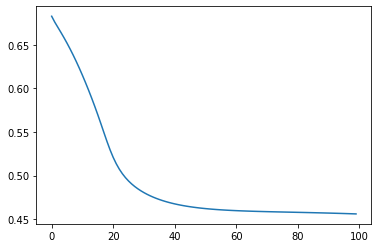

In [17]:
plt.plot(perceptron3.loss_list)
plt.show()

The graph indicates a pretty good decrease, and the prospective is good. Let's apply some metrics to the model:

In [18]:
acc = accuracy_score(y_predicted3, y_test2)
auc_pr = average_precision_score(y_test2, perceptron3.predict_proba(X_test2)[:, 1])
auc_roc = roc_auc_score(y_test2, perceptron3.predict_proba(X_test2)[:, 1])
print('Accuracy:', acc, '\n', 'AUC-PR:', auc_pr, '\n', 'AUC-ROC:', auc_roc)

Accuracy: 0.8 
 AUC-PR: 0.8669767180997745 
 AUC-ROC: 0.8671499733143568


And, at last, let's take a look at our confusion matrix:

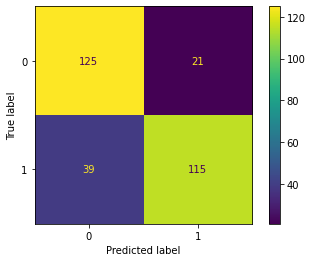

In [19]:
conf_mat = confusion_matrix(y_test2, y_predicted3)
disp = ConfusionMatrixDisplay(conf_mat)
disp.plot()
plt.show()

## Part 3 – – Random forest for classification
Let's load the dataset from the UCI archive:

In [20]:
data3 = pd.read_table('adultdata.csv', sep=',', header = None)
data3 = data3.sample(3000)
data3

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
22753,28,Private,266070,Some-college,10,Never-married,Exec-managerial,Not-in-family,White,Female,0,0,40,United-States,<=50K
17888,32,Private,228265,HS-grad,9,Never-married,Handlers-cleaners,Own-child,White,Female,0,0,30,United-States,<=50K
21122,28,Private,71733,Some-college,10,Separated,Other-service,Unmarried,White,Female,0,0,15,United-States,<=50K
5579,27,Private,255582,HS-grad,9,Never-married,Machine-op-inspct,Not-in-family,White,Female,0,0,40,United-States,<=50K
26647,40,Local-gov,99679,Prof-school,15,Never-married,Exec-managerial,Not-in-family,White,Male,0,0,60,United-States,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24387,38,Private,115289,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,<=50K
18897,30,Local-gov,178383,Some-college,10,Separated,Handlers-cleaners,Not-in-family,Black,Male,0,0,40,United-States,<=50K
26912,32,Self-emp-inc,103078,Bachelors,13,Married-civ-spouse,Sales,Husband,White,Male,0,0,40,United-States,<=50K
6736,22,Private,199555,Some-college,10,Never-married,Farming-fishing,Own-child,White,Male,0,0,25,United-States,<=50K


As always, it's needed to divide it in X and y, and also into training and testing sets:

In [21]:
X3 = data3.loc[:, 0:13].to_numpy()
y3 = data3.loc[:, 14].to_numpy()
y3= y3[:,np.newaxis]
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size = 0.3)

Now we can write our code for the decision tree. Note that we wish to implement a Random Forest Algorithm, but it's basically a bunch of decision trees that go through bagging (bootstraping and aggregation). For the tree itself, we'll need a class Node, to keep our moves in track for recursion. In the Data Structures discipline we've done this quite a lot, so it seems like the best way to develop this code.

In [22]:
class Node():
    def __init__(self, feat_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        self.feat_index = feat_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        self.value = value #used in leafs, stores the predicted value

class DecisionTreeClassifier():
    def __init__(self, min_samples=2, max_depth=2):
        self.min_samples = min_samples
        self.max_depth = max_depth
        self.root = None
                            
    def build_tree(self, X, y, depth = 0):
        if X.shape[0]>=self.min_samples and depth<=self.max_depth:
            best_split = self.get_best_split(X, y)
            if 'info_gain' not in best_split.keys():
                best_split['info_gain'] = -float("inf")
            if best_split['info_gain']>0:
                left_recur = self.build_tree(best_split['left_X'], best_split['left_y'], depth+1)
                right_recur = self.build_tree(best_split['right_X'], best_split['right_y'], depth+1)
                # as criteria wasn't met, we return a decision node
                return Node(best_split['feat_index'], best_split['threshold'], left_recur, right_recur, best_split['info_gain'], None)

        # if criteria was met, we return a leaf node
        leaf_value = self.calculate_leaf_value(y)
        return Node(value=leaf_value)
    
    def get_best_split(self, X, y):
        best_split = {}
        max_info_gain = -float("inf")

        for feat_index in range(X.shape[1]): 
            thresholds = np.unique(X[:,feat_index])
            # get all unique values to try for this feature
            for threshold in thresholds:
                left_X, left_y, right_X, right_y = self.split(X, y, feat_index, threshold)
                if len(left_X)>0 and len(right_X)>0:
                    curr_info_gain = self.information_gain(y, left_y, right_y)
                    # if info gain is greater than the best info gain, we update the best split
                    if curr_info_gain>max_info_gain:
                        best_split["feat_index"] = feat_index
                        best_split["threshold"] = threshold
                        best_split["left_X"] = left_X
                        best_split["left_y"] = left_y
                        best_split["right_X"] = right_X
                        best_split["right_y"] = right_y
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain
        return best_split
    
    def fit(self, X, y):
        self.root = self.build_tree(X, y)

    def split(self, X, y, feat_index, threshold):
        left_X = X[X[:, feat_index] <= threshold]
        left_y = y[X[:, feat_index] <= threshold]
        right_X = X[X[:, feat_index] > threshold]
        right_y = y[X[:, feat_index] > threshold]
        return left_X, left_y, right_X, right_y

    def information_gain(self, y, left_node, right_node):       
        calc_left = len(left_node) / y.shape[0]
        calc_right = len(right_node) / y.shape[0]
        # calculates entropy to check information gain on a possible split
        gain = self.entropy(y) - (calc_left*self.entropy(left_node) + calc_right*self.entropy(right_node))
        return gain
    
    def entropy(self, y):
        # entropy calc
        classes = np.unique(y)
        entropy = 0

        for c in classes:
            p = len(y[y==c])/y.shape[0]
            entropy += -p * np.log2(p)
        return entropy
    
    def calculate_leaf_value(self, y):
        y = list(y)
        return max(y, key=y.count)

    def predict(self, X):
        return np.array([self.predict_row(row) for row in X])

    def predict_row(self, row):
        node = self.root
        while node.value is None:
            if row[node.feat_index] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node.value

Let's try the code:

In [23]:
tree = DecisionTreeClassifier(min_samples=2,max_depth=2)
tree.fit(X_train3, y_train3)

The tree seems to make sense! Let's check our predictions and, at last, accuracy of the model:

In [24]:
np.c_[tree.predict(X_test3)[0:10], y_test3[0:10]]

array([[' <=50K', ' <=50K'],
       [' >50K', ' >50K'],
       [' <=50K', ' <=50K'],
       [' <=50K', ' <=50K'],
       [' <=50K', ' <=50K'],
       [' <=50K', ' <=50K'],
       [' <=50K', ' <=50K'],
       [' <=50K', ' <=50K'],
       [' <=50K', ' <=50K'],
       [' <=50K', ' >50K']], dtype=object)

In [25]:
acc = accuracy_score(y_test3, tree.predict(X_test3))
acc

0.8088888888888889

Let's move on to the Random Forest:

In [26]:
# auxiliar function to predict
def most_common_label(y):
        return dict(zip(*np.unique(y, return_counts=True)))

class RandomForest():
    def __init__(self, n_trees=10, min_samples=5, max_depth=3):
        self.n_trees = n_trees
        self.min_samples = min_samples
        self.max_depth = max_depth
        self.trees = []
        self.lista = []

    def bootstrap_sample(self, X, y):
        # we should be able to call this function to generate subsets of X with the same number of samples, but randomly (and possibly with repeated lines)
        sample_indices = np.random.randint(low=0, high=len(X), size=len(X))
        return X[sample_indices], y[sample_indices]

    def aggregate_predictions(self, X, y):
        num_col = round(np.log(X.shape[1]))
        sample_indices = np.random.choice(X.shape[1], size=(X.shape[1]-num_col), replace=False)
        X[:,sample_indices] = 0
        return X, y

    def fit(self, X, y):
        for t in range(self.n_trees):
            X_sample, y_sample = self.bootstrap_sample(X, y)
            X_sample, y_sample = self.aggregate_predictions(X_sample, y_sample)
            tree = DecisionTreeClassifier(min_samples=self.min_samples, max_depth=self.max_depth)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)
        
    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        predictions = np.swapaxes(predictions, 0, 1)
        temp = np.array([most_common_label(pred) for pred in predictions])

        for row in temp:
            self.lista.append(max(row, key = row.get))
        return np.array(self.lista).reshape(-1,1) 
    
    def predict_proba(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        predictions = np.swapaxes(predictions, 0, 1)
        return predictions

In [27]:
rf = RandomForest(n_trees=11, min_samples=2, max_depth=2)
rf.fit(X_train3, y_train3)
y_pred = rf.predict(X_test3)

In [28]:
acc = accuracy_score(y_test3, y_pred)
acc

0.7655555555555555

## Part 4 - Performance comparison

Now we wish to use our Multilayer Perceptron and Random Forest on the dataset 2, and also on 3 other classifiers from sklearn, and I chose KNN, Adaboost and GaussianNB. We'll train them, do predictions on the test set. Let's check the accuracies:


In [ ]:
perceptron_data2 = PerceptronClassifier(hidden_layer_dimensions=[10,10,10,10], epochs=100, learning_rate=0.001, batch_size=32)
perceptron_data2.fit(X_train2, y_train2)
y_perceptron2 = perceptron_data2.predict(X_test2) > 0.5
acc = accuracy_score(y_test2, y_perceptron2)
acc

0.85

In [ ]:
randomforest_data2 = RandomForest(n_trees=11, min_samples=2, max_depth=2)
randomforest_data2.fit(X_train2, y_train2)
y_randomforest2 = randomforest_data2.predict(X_test2)
acc = accuracy_score(y_test2, y_randomforest2)
acc

0.9066666666666666

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train2, y_train2)
y_knn2 = knn.predict(X_test2)
acc = accuracy_score(y_test2, y_knn2)
acc

0.9266666666666666

In [ ]:
adaboost = AdaBoostClassifier(n_estimators=100)
adaboost.fit(X_train2, y_train2)
y_adaboost2 = adaboost.predict(X_test2)
acc = accuracy_score(y_test2, y_adaboost2)
acc

0.9233333333333333

In [ ]:
gaussiannb = GaussianNB()
gaussiannb.fit(X_train2, y_train2)
y_gaussiannb2 = gaussiannb.predict(X_test2)
acc = accuracy_score(y_test2, y_gaussiannb2)
acc

0.7866666666666666

Now let's try some performance metrics on each of them:

In [ ]:
# perceptron
precision_perc = precision_score(y_test2, y_perceptron2)
recall_perc = recall_score(y_test2, y_perceptron2)
auc_roc_perc = roc_auc_score(y_test2, perceptron_data2.predict_proba(X_test2)[:, 1])
auc_pr_perc = average_precision_score(y_test2, perceptron_data2.predict_proba(X_test2)[:, 1])
print('Perceptron:', '\n', 'Precision:', precision_perc, '\n', 'Recall', recall_perc, '\n', 'AUC-ROC:', auc_roc_perc, '\n', 'AUC-PR:', auc_pr_perc)

Perceptron: 
 Precision: 0.918918918918919 
 Recall 0.8047337278106509 
 AUC-ROC: 0.9155336736076607 
 AUC-PR: 0.9383921044150177


In [ ]:
# random forest
precision_rf = precision_score(y_test2, y_randomforest2)
recall_rf = recall_score(y_test2, y_randomforest2)
auc_roc_rf = roc_auc_score(y_test2, randomforest_data2.predict_proba(X_test2)[:, 1])
auc_pr_rf = average_precision_score(y_test2, randomforest_data2.predict_proba(X_test2)[:, 1])
print('Random Forest:', '\n', 'Precision:', precision_rf, '\n', 'Recall', recall_rf, '\n', 'AUC-ROC:', auc_roc_rf, '\n', 'AUC-PR:', auc_pr_rf)

Random Forest: 
 Precision: 0.873015873015873 
 Recall 0.9763313609467456 
 AUC-ROC: 0.8183070599394733 
 AUC-PR: 0.7949901380670612


In [ ]:
# knn
precision_knn = precision_score(y_test2, y_knn2)
recall_knn = recall_score(y_test2, y_knn2)
auc_roc_knn = roc_auc_score(y_test2, knn.predict_proba(X_test2)[:, 1])
auc_pr_knn = average_precision_score(y_test2, knn.predict_proba(X_test2)[:, 1])
print('KNN:', '\n', 'Precision:', precision_knn, '\n', 'Recall', recall_knn, '\n', 'AUC-ROC:', auc_roc_knn, '\n', 'AUC-PR:', auc_pr_knn)

KNN: 
 Precision: 0.9248554913294798 
 Recall 0.9467455621301775 
 AUC-ROC: 0.9344821355978139 
 AUC-PR: 0.9166959799152976


In [ ]:
# adaboost
precision_ad = precision_score(y_test2, y_adaboost2)
recall_ad = recall_score(y_test2, y_adaboost2)
auc_roc_ad = roc_auc_score(y_test2, adaboost.predict_proba(X_test2)[:, 1])
auc_pr_ad = average_precision_score(y_test2, adaboost.predict_proba(X_test2)[:, 1])
print('Adaboost:', '\n', 'Precision:', precision_ad, '\n', 'Recall', recall_ad, '\n', 'AUC-ROC:', auc_roc_ad, '\n', 'AUC-PR:', auc_pr_ad)

Adaboost: 
 Precision: 0.9244186046511628 
 Recall 0.9408284023668639 
 AUC-ROC: 0.9688106960567326 
 AUC-PR: 0.9755586213568668


In [ ]:
# gaussian naive bayes
precision_nv = precision_score(y_test2, y_gaussiannb2)
recall_nv = recall_score(y_test2, y_gaussiannb2)
auc_roc_nv = roc_auc_score(y_test2, gaussiannb.predict_proba(X_test2)[:, 1])
auc_pr_nv = average_precision_score(y_test2, gaussiannb.predict_proba(X_test2)[:, 1])
print('Gaussian Naive Bayes:', '\n', 'Precision:', precision_nv, '\n', 'Recall', recall_nv, '\n', 'AUC-ROC:', auc_roc_nv, '\n', 'AUC-PR:', auc_pr_nv)

Gaussian Naive Bayes: 
 Precision: 0.7932960893854749 
 Recall 0.8402366863905325 
 AUC-ROC: 0.9064095035909481 
 AUC-PR: 0.9275394932246566


Now we'll do the comparison report. Here's the table with all the metrics we've calculated

In [ ]:
header = ['Model', 'Precision', 'Recall', 'AUC-ROC', 'AUC-PR']
perceptron_ = ['Perceptron', precision_perc, recall_perc, auc_roc_perc, auc_pr_perc]
randomforest_ = ['Random Forest', precision_rf, recall_rf, auc_roc_rf, auc_pr_rf]
knn_ = ['KNN', precision_knn, recall_knn, auc_roc_knn, auc_pr_knn]
adaboost_ = ['Adaboost', precision_ad, recall_ad, auc_roc_ad, auc_pr_ad]
gaussiannb_ = ['Gaussian Naive Bayes', precision_nv, recall_nv, auc_roc_nv, auc_pr_nv]

models_df = pd.DataFrame([perceptron_, randomforest_, knn_, adaboost_, gaussiannb_], columns = header)
models_df

,Model,Precision,Recall,AUC-ROC,AUC-PR
0,Perceptron,0.918919,0.804734,0.915534,0.938392
1,Random Forest,0.873016,0.976331,0.818307,0.794990
2,KNN,0.924855,0.946746,0.934482,0.916696
3,Adaboost,0.924419,0.940828,0.968811,0.975559
4,Gaussian Naive Bayes,0.793296,0.840237,0.906410,0.927539


And at very last, here is the plot of ROC and PR curves of all classifiers:

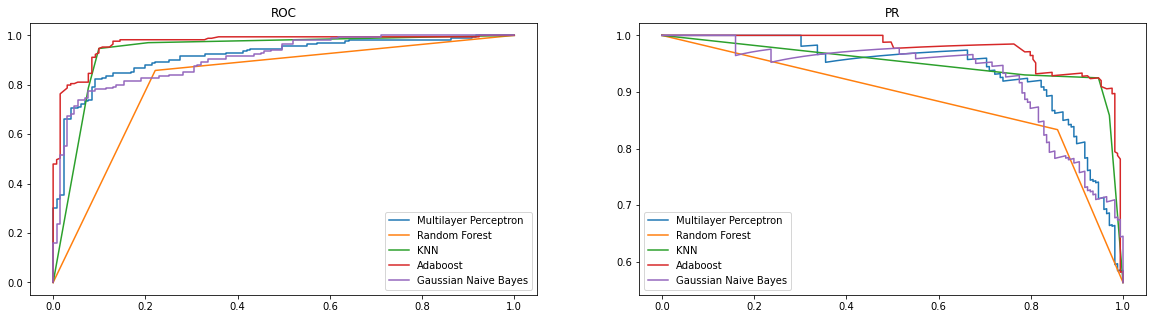

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (20,5))

for proba in [perceptron_data2.predict_proba(X_test2)[:, 1],randomforest_data2.predict_proba(X_test2)[:, 1],knn.predict_proba(X_test2)[:, 1], adaboost.predict_proba(X_test2)[:, 1], gaussiannb.predict_proba(X_test2)[:, 1]]:
    i, j, thresholds = roc_curve(y_test2, proba)
    ax[0].plot(i, j, label = 'ROC curve')

for proba in [perceptron_data2.predict_proba(X_test2)[:, 1],randomforest_data2.predict_proba(X_test2)[:, 1],knn.predict_proba(X_test2)[:, 1], adaboost.predict_proba(X_test2)[:, 1], gaussiannb.predict_proba(X_test2)[:, 1]]:
    precision, recall, thresholds = precision_recall_curve(y_test2, proba)
    ax[1].plot(recall, precision, label = 'PR curve')

ax[0].set_title('ROC')
ax[1].set_title('PR')
ax[0].legend(['Multilayer Perceptron', 'Random Forest', 'KNN', 'Adaboost', 'Gaussian Naive Bayes'])
ax[1].legend(['Multilayer Perceptron', 'Random Forest', 'KNN', 'Adaboost', 'Gaussian Naive Bayes'])